# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
    #env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()
# env.close()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200000             # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    episode_reward = deque(maxlen=100) # running average    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        # After each episode
        rewards_list.append((ep, total_reward))
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'MeanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'Loss:{:.4f}'.format(loss),
              'ExploreP:{:.4f}'.format(explore_p))
        if np.mean(episode_reward) >= 500:
            break
            
    # save the model at the end of all training episodes
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 MeanR:27.0000 R: 27.0 Loss: 0.9930 ExploreP: 0.9973
Episode: 2 MeanR:22.5000 R: 18.0 Loss: 0.9942 ExploreP: 0.9956
Episode: 3 MeanR:21.6667 R: 20.0 Loss: 1.0328 ExploreP: 0.9936
Episode: 4 MeanR:23.2500 R: 28.0 Loss: 0.9970 ExploreP: 0.9908
Episode: 5 MeanR:21.0000 R: 12.0 Loss: 0.9940 ExploreP: 0.9897
Episode: 6 MeanR:19.8333 R: 14.0 Loss: 0.9815 ExploreP: 0.9883
Episode: 7 MeanR:21.0000 R: 28.0 Loss: 1.0247 ExploreP: 0.9856
Episode: 8 MeanR:20.0000 R: 13.0 Loss: 1.0561 ExploreP: 0.9843
Episode: 9 MeanR:19.1111 R: 12.0 Loss: 1.0187 ExploreP: 0.9831
Episode: 10 MeanR:18.9000 R: 17.0 Loss: 0.9490 ExploreP: 0.9815
Episode: 11 MeanR:18.7273 R: 17.0 Loss: 1.1009 ExploreP: 0.9798
Episode: 12 MeanR:19.5000 R: 28.0 Loss: 1.0319 ExploreP: 0.9771
Episode: 13 MeanR:19.0769 R: 14.0 Loss: 1.0199 ExploreP: 0.9757
Episode: 14 MeanR:18.8571 R: 16.0 Loss: 0.9594 ExploreP: 0.9742
Episode: 15 MeanR:18.2000 R: 9.0 Loss: 1.2634 ExploreP: 0.9733
Episode: 16 MeanR:18.6250 R: 25.0 Loss: 1.1009 Exp

Episode: 132 MeanR:21.8400 R: 17.0 Loss: 0.3855 ExploreP: 0.7566
Episode: 133 MeanR:21.8000 R: 13.0 Loss: 129.5027 ExploreP: 0.7556
Episode: 134 MeanR:21.8400 R: 24.0 Loss: 0.8497 ExploreP: 0.7538
Episode: 135 MeanR:21.7900 R: 21.0 Loss: 312.6091 ExploreP: 0.7523
Episode: 136 MeanR:21.7300 R: 18.0 Loss: 0.3413 ExploreP: 0.7509
Episode: 137 MeanR:21.5000 R: 24.0 Loss: 0.8498 ExploreP: 0.7492
Episode: 138 MeanR:21.7100 R: 33.0 Loss: 0.6209 ExploreP: 0.7467
Episode: 139 MeanR:21.7900 R: 25.0 Loss: 0.7856 ExploreP: 0.7449
Episode: 140 MeanR:21.6000 R: 14.0 Loss: 0.7668 ExploreP: 0.7439
Episode: 141 MeanR:21.6200 R: 30.0 Loss: 132.8302 ExploreP: 0.7417
Episode: 142 MeanR:21.5700 R: 9.0 Loss: 109.7969 ExploreP: 0.7410
Episode: 143 MeanR:21.5900 R: 18.0 Loss: 0.7070 ExploreP: 0.7397
Episode: 144 MeanR:21.6600 R: 19.0 Loss: 125.3307 ExploreP: 0.7383
Episode: 145 MeanR:21.5100 R: 22.0 Loss: 0.7793 ExploreP: 0.7367
Episode: 146 MeanR:21.6500 R: 24.0 Loss: 1.2483 ExploreP: 0.7350
Episode: 147 Mea

Episode: 258 MeanR:17.8300 R: 10.0 Loss: 94.2040 ExploreP: 0.6040
Episode: 259 MeanR:17.8200 R: 17.0 Loss: 82.3912 ExploreP: 0.6029
Episode: 260 MeanR:17.8200 R: 18.0 Loss: 78.8140 ExploreP: 0.6019
Episode: 261 MeanR:17.6600 R: 10.0 Loss: 64.3849 ExploreP: 0.6013
Episode: 262 MeanR:17.3200 R: 11.0 Loss: 0.8759 ExploreP: 0.6006
Episode: 263 MeanR:17.0200 R: 9.0 Loss: 0.7232 ExploreP: 0.6001
Episode: 264 MeanR:17.0100 R: 12.0 Loss: 92.0887 ExploreP: 0.5994
Episode: 265 MeanR:17.0300 R: 23.0 Loss: 69.5312 ExploreP: 0.5980
Episode: 266 MeanR:16.9800 R: 12.0 Loss: 0.8240 ExploreP: 0.5973
Episode: 267 MeanR:16.9300 R: 9.0 Loss: 0.6940 ExploreP: 0.5968
Episode: 268 MeanR:16.9500 R: 15.0 Loss: 0.8239 ExploreP: 0.5959
Episode: 269 MeanR:16.9600 R: 11.0 Loss: 0.6401 ExploreP: 0.5953
Episode: 270 MeanR:16.7600 R: 29.0 Loss: 91.1557 ExploreP: 0.5936
Episode: 271 MeanR:16.7900 R: 15.0 Loss: 100.7286 ExploreP: 0.5927
Episode: 272 MeanR:16.8000 R: 10.0 Loss: 80.1571 ExploreP: 0.5921
Episode: 273 Mean

Episode: 383 MeanR:29.8400 R: 67.0 Loss: 33.5193 ExploreP: 0.4342
Episode: 384 MeanR:30.5600 R: 80.0 Loss: 0.8762 ExploreP: 0.4308
Episode: 385 MeanR:30.9200 R: 45.0 Loss: 1.1541 ExploreP: 0.4289
Episode: 386 MeanR:31.2200 R: 44.0 Loss: 23.4301 ExploreP: 0.4270
Episode: 387 MeanR:31.4300 R: 28.0 Loss: 19.3918 ExploreP: 0.4259
Episode: 388 MeanR:32.8000 R: 147.0 Loss: 0.6043 ExploreP: 0.4198
Episode: 389 MeanR:33.4200 R: 76.0 Loss: 1.1663 ExploreP: 0.4167
Episode: 390 MeanR:33.8500 R: 58.0 Loss: 1.3162 ExploreP: 0.4144
Episode: 391 MeanR:34.1900 R: 45.0 Loss: 17.7218 ExploreP: 0.4125
Episode: 392 MeanR:34.5000 R: 42.0 Loss: 21.3257 ExploreP: 0.4109
Episode: 393 MeanR:34.8600 R: 49.0 Loss: 60.1616 ExploreP: 0.4089
Episode: 394 MeanR:35.3700 R: 62.0 Loss: 0.9830 ExploreP: 0.4064
Episode: 395 MeanR:34.9700 R: 31.0 Loss: 1.3066 ExploreP: 0.4052
Episode: 396 MeanR:35.3100 R: 46.0 Loss: 1.3904 ExploreP: 0.4034
Episode: 397 MeanR:35.5000 R: 33.0 Loss: 1.5367 ExploreP: 0.4021
Episode: 398 MeanR

Episode: 509 MeanR:88.9200 R: 65.0 Loss: 1.4836 ExploreP: 0.1582
Episode: 510 MeanR:89.2800 R: 78.0 Loss: 1.5441 ExploreP: 0.1571
Episode: 511 MeanR:89.8300 R: 100.0 Loss: 193.2191 ExploreP: 0.1556
Episode: 512 MeanR:90.2800 R: 77.0 Loss: 1.5069 ExploreP: 0.1545
Episode: 513 MeanR:90.9500 R: 97.0 Loss: 271.0303 ExploreP: 0.1531
Episode: 514 MeanR:91.8400 R: 132.0 Loss: 2.1094 ExploreP: 0.1512
Episode: 515 MeanR:92.0000 R: 96.0 Loss: 1.4067 ExploreP: 0.1499
Episode: 516 MeanR:92.6000 R: 123.0 Loss: 1.4237 ExploreP: 0.1482
Episode: 517 MeanR:93.3600 R: 120.0 Loss: 1.1398 ExploreP: 0.1465
Episode: 518 MeanR:93.8900 R: 117.0 Loss: 0.9592 ExploreP: 0.1449
Episode: 519 MeanR:94.3600 R: 72.0 Loss: 1.1694 ExploreP: 0.1440
Episode: 520 MeanR:94.0700 R: 46.0 Loss: 1.2497 ExploreP: 0.1433
Episode: 521 MeanR:94.5800 R: 92.0 Loss: 1.2919 ExploreP: 0.1421
Episode: 522 MeanR:95.0800 R: 124.0 Loss: 3.1754 ExploreP: 0.1405
Episode: 523 MeanR:95.4200 R: 71.0 Loss: 0.6230 ExploreP: 0.1396
Episode: 524 Me

Episode: 632 MeanR:173.8600 R: 499.0 Loss: 0.1508 ExploreP: 0.0287
Episode: 633 MeanR:176.3800 R: 499.0 Loss: 16.0527 ExploreP: 0.0278
Episode: 634 MeanR:179.1000 R: 440.0 Loss: 0.1946 ExploreP: 0.0270
Episode: 635 MeanR:180.7600 R: 421.0 Loss: 0.1334 ExploreP: 0.0263
Episode: 636 MeanR:179.5000 R: 48.0 Loss: 0.2612 ExploreP: 0.0262
Episode: 637 MeanR:183.4100 R: 499.0 Loss: 0.1369 ExploreP: 0.0254
Episode: 638 MeanR:185.8000 R: 391.0 Loss: 0.1428 ExploreP: 0.0249
Episode: 639 MeanR:186.9600 R: 365.0 Loss: 0.2293 ExploreP: 0.0243
Episode: 640 MeanR:188.8800 R: 477.0 Loss: 0.2404 ExploreP: 0.0237
Episode: 641 MeanR:192.4200 R: 492.0 Loss: 0.2242 ExploreP: 0.0230
Episode: 642 MeanR:195.3700 R: 499.0 Loss: 0.2125 ExploreP: 0.0224
Episode: 643 MeanR:198.4200 R: 499.0 Loss: 0.1096 ExploreP: 0.0218
Episode: 644 MeanR:201.2800 R: 499.0 Loss: 201.3148 ExploreP: 0.0212
Episode: 645 MeanR:204.8500 R: 499.0 Loss: 0.2160 ExploreP: 0.0206
Episode: 646 MeanR:208.4800 R: 499.0 Loss: 0.1629 ExploreP: 

Episode: 756 MeanR:143.0900 R: 499.0 Loss: 4.9975 ExploreP: 0.0115
Episode: 757 MeanR:143.0900 R: 499.0 Loss: 1.4637 ExploreP: 0.0114
Episode: 758 MeanR:145.0900 R: 499.0 Loss: 3.0991 ExploreP: 0.0113
Episode: 759 MeanR:147.0900 R: 499.0 Loss: 5.9471 ExploreP: 0.0113
Episode: 760 MeanR:149.5000 R: 499.0 Loss: 0.2735 ExploreP: 0.0112
Episode: 761 MeanR:151.7700 R: 499.0 Loss: 17.1714 ExploreP: 0.0111
Episode: 762 MeanR:153.1100 R: 499.0 Loss: 60.3738 ExploreP: 0.0111
Episode: 763 MeanR:155.1600 R: 499.0 Loss: 1.0307 ExploreP: 0.0110
Episode: 764 MeanR:155.9700 R: 499.0 Loss: 1.3360 ExploreP: 0.0110
Episode: 765 MeanR:156.2000 R: 499.0 Loss: 0.3392 ExploreP: 0.0109
Episode: 766 MeanR:156.2000 R: 499.0 Loss: 0.2394 ExploreP: 0.0109
Episode: 767 MeanR:156.2000 R: 499.0 Loss: 0.4845 ExploreP: 0.0108
Episode: 768 MeanR:156.2000 R: 499.0 Loss: 0.6176 ExploreP: 0.0108
Episode: 769 MeanR:156.2000 R: 499.0 Loss: 0.1947 ExploreP: 0.0108
Episode: 770 MeanR:157.3500 R: 499.0 Loss: 0.3356 ExploreP: 

Episode: 879 MeanR:483.2700 R: 499.0 Loss: 0.0876 ExploreP: 0.0100
Episode: 880 MeanR:483.2700 R: 499.0 Loss: 0.0630 ExploreP: 0.0100
Episode: 881 MeanR:483.6300 R: 499.0 Loss: 181.9871 ExploreP: 0.0100
Episode: 882 MeanR:484.3600 R: 499.0 Loss: 0.1228 ExploreP: 0.0100
Episode: 883 MeanR:485.3000 R: 499.0 Loss: 0.1448 ExploreP: 0.0100
Episode: 884 MeanR:485.8800 R: 499.0 Loss: 0.0707 ExploreP: 0.0100
Episode: 885 MeanR:486.7200 R: 499.0 Loss: 0.0574 ExploreP: 0.0100
Episode: 886 MeanR:488.2800 R: 499.0 Loss: 0.0490 ExploreP: 0.0100
Episode: 887 MeanR:489.4000 R: 499.0 Loss: 0.0422 ExploreP: 0.0100
Episode: 888 MeanR:490.9000 R: 499.0 Loss: 0.1167 ExploreP: 0.0100
Episode: 889 MeanR:491.0400 R: 499.0 Loss: 0.1066 ExploreP: 0.0100
Episode: 890 MeanR:492.6200 R: 499.0 Loss: 0.0861 ExploreP: 0.0100
Episode: 891 MeanR:493.7600 R: 499.0 Loss: 193.7801 ExploreP: 0.0100
Episode: 892 MeanR:495.4300 R: 499.0 Loss: 0.0728 ExploreP: 0.0100
Episode: 893 MeanR:496.6400 R: 499.0 Loss: 0.0753 ExploreP

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

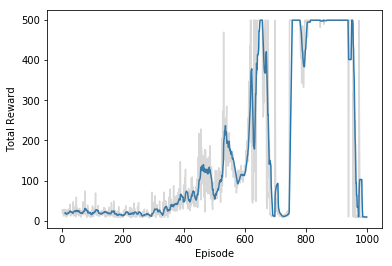

In [20]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [15]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [16]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.